In [96]:
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import pickle
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import sys

In [ ]:
base_dir = '/home/reutme/Big_data/final_project'
code_dir = os.path.join(base_dir, 'code')
sys.path.append(code_dir)
import const
import params

### Find pattern in authors cunt infuence by war time in institution level

In [10]:
top_countries_named = ['SD', 'US', 'AO', 'VN', 'GT', 'ET', 'AF', 'ER', 'MZ', 'RU', 'LK', 'KH', 'IQ', 'DZ', 'CN']


In [2]:
input_dir = os.path.join(const.data_base_dir, "processed_chunks_combine_war_openalex")

In [7]:
def process_authors_data(input_dir, year_min=1980, year_max=2000, country_list=None):
    """
    Process war data from pickle files in the given directory and normalize by the average number of authors per country.
    Allows filtering by a specific list of country codes.

    Args:
        input_dir (str): Directory where yearly pickle files are stored.
        iso_conversion_func (function): Function to convert 2-letter ISO codes to 3-letter ISO codes.
        war (int): 1 for war exist, 0 for no war.
        year_min (int): Minimum year to process.
        year_max (int): Maximum year to process.
        country_list (list, optional): List of country codes to filter by (default: None, meaning all countries).

    Returns:
        pd.DataFrame: DataFrame with war counts normalized by the average number of authors per country.
    """

    all_authors_data = []  # List to store total authors per country per year

    for year in range(year_min + 1, year_max + 1):
        print(f"start with year {year}")
        pickle_file = f'year_{year}.pkl'
        file_path = os.path.join(input_dir, pickle_file)

        # Read only 'publication_year' and 'country_code' columns
        df = pd.read_pickle(file_path)

        # Filter based on country list (if provided)
        if country_list is not None:
            df = df[df["country_code"].isin(country_list)]

        # Group by publication year and country, keeping war-related columns
        grouped_df = df.groupby(["publication_year", "country_code", "institution_name"]).agg(
            authors_count=("publication_year", "count"),
            war_exist=("war_exist", "first"),  # If any record has war_exist=1, keep it
            year_in_war=("year_in_war", "first"),  # Keep max value for war duration
            war_name=("war_name", lambda x: ', '.join(x.unique()))  # Keep unique war names
        ).reset_index()

        all_authors_data.append(grouped_df)
        print(f"Finished processing year {year}.")

    # Combine all years into a single DataFrame
    author_data = pd.concat(all_authors_data, ignore_index=True)

    author_data = author_data.sort_values(by=["publication_year", "country_code", "institution_name"]).reset_index(drop=True)

    return author_data


In [8]:
author_data = process_authors_data(input_dir, year_min=1950, year_max=2022)


start with year 1951
Finished processing year 1951.
start with year 1952
Finished processing year 1952.
start with year 1953
Finished processing year 1953.
start with year 1954
Finished processing year 1954.
start with year 1955
Finished processing year 1955.
start with year 1956
Finished processing year 1956.
start with year 1957
Finished processing year 1957.
start with year 1958
Finished processing year 1958.
start with year 1959
Finished processing year 1959.
start with year 1960
Finished processing year 1960.
start with year 1961
Finished processing year 1961.
start with year 1962
Finished processing year 1962.
start with year 1963
Finished processing year 1963.
start with year 1964
Finished processing year 1964.
start with year 1965
Finished processing year 1965.
start with year 1966
Finished processing year 1966.
start with year 1967
Finished processing year 1967.
start with year 1968
Finished processing year 1968.
start with year 1969
Finished processing year 1969.
start with y

In [27]:
author_data.head()

,publication_year,country_code,institution_name,authors_count,war_exist,year_in_war,war_name
0,1951,AM,Institute of Botany,1,0,0,No War
1,1951,AM,Institute of Radiophysics and Electronics,5,0,0,No War
2,1951,AM,National Institute of Health,47,0,0,No War
3,1951,AR,Academia Nacional de Medicina,5,0,0,No War
4,1951,AR,Bernardino Rivadavia Natural Sciences Museum,3,0,0,No War


In [11]:
# with open(os.path.join(const.data_base_dir, "authors_data_count_by_institution.pkl"), "wb") as file:
#     pickle.dump(author_data, file)
    

In [21]:
year_list = [1987, 1993, 2003, 2012, 2015, 2019]

In [28]:
grouped_data = author_data[author_data['country_code'].isin(top_countries_named)]
grouped_data = grouped_data[author_data['publication_year'].isin(year_list)]

/tmp/ipykernel_924840/1592833622.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grouped_data = grouped_data[author_data['publication_year'].isin(year_list)]


In [29]:
grouped_data.head()

,publication_year,country_code,institution_name,authors_count,war_exist,year_in_war,war_name
465910,1987,AF,Kabul University,1,1,0,Soviet–Afghan War
465911,1987,AF,Ministry of Public Health,1,1,0,Soviet–Afghan War
465912,1987,AF,World Health Organization - Afghanistan,7,1,0,Soviet–Afghan War
465930,1987,AO,Agostinho Neto University,1,1,0,Angolan Civil War
465931,1987,AO,Instituto Superior de Ciencias Sociais e Relaç...,1,1,0,Angolan Civil War


In [38]:
def calculate_correlation(df):
    """
    Calculates Pearson and Spearman correlation between 'publication_year' and 'authors_count' for each country & institution.
    
    Handles cases where correlation is undefined (e.g., constant values).
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing 'country_code', 'institution_name', 'publication_year', and 'authors_count'.

    Returns:
    pd.DataFrame: A DataFrame containing Pearson and Spearman correlation coefficients for each country & institution.
    """
    valid_institutions = df.groupby(["country_code", "institution_name"])["publication_year"].nunique()
    valid_institutions = valid_institutions[valid_institutions == 6].index  # Keep only those with 6 years

    # Filter dataset to include only valid institutions
    df_filtered = df[df.set_index(["country_code", "institution_name"]).index.isin(valid_institutions)].copy()

    # Function to compute correlation safely
    def safe_correlation(x):
        if x["publication_year"].nunique() != 6:
            return pd.Series({"pearson_corr": np.nan, "spearman_corr": np.nan})  # Avoids errors if there's no variation
        return pd.Series({
            "pearson_corr": x["publication_year"].corr(x["authors_count"]),
            "spearman_corr": stats.spearmanr(x["publication_year"], x["authors_count"])[0]
        })

    # Group by country & institution, then apply the safe correlation function
    correlation_results = df_filtered.groupby(["country_code", "institution_name"]).apply(safe_correlation).reset_index()

    return correlation_results

In [39]:
correlation_df = calculate_correlation(grouped_data)

correlation_df = correlation_df.sort_values(by="pearson_corr", ascending=False)

/home/reutme/.conda/envs/muscle_diff/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [42]:
correlation_df.head()

,country_code,institution_name,pearson_corr,spearman_corr
4588,US,National Institute of Standards and Technology,0.998966,1.0
4592,US,National Institutes of Health,0.996761,1.0
5271,US,Public Health – Seattle & King County,0.996478,1.0
6831,US,Washington Department of Fish and Wildlife,0.996127,1.0
2001,US,Bryant University,0.995984,1.0


In [41]:
correlation_df['country_code'].value_counts()

US    5795
CN     708
RU     449
DZ      30
LK      20
VN      19
GT      12
ET       9
IQ       8
SD       7
MZ       6
KH       5
AO       2
AF       1
Name: country_code, dtype: int64

In [48]:
ru_filtered = correlation_df[
    (correlation_df["country_code"] == "RU") &  # Select only Russia
    (correlation_df["pearson_corr"].between(-0.2, 0.2))  # Pearson correlation in the range
]
print(ru_filtered.shape, ru_filtered.head())

(18, 4)      country_code                                   institution_name  \
857            RU              Central Research and Design Institute   
1134           RU  Research Institute of Scientific Research and ...   
1193           RU               Taganrog State Pedagogical Institute   
1218           RU                           Ural Institute of Metals   
1184           RU     State Optical Institute named after SI Vavilov   

      pearson_corr  spearman_corr  
857       0.177720       0.085714  
1134      0.170917       0.144943  
1193      0.137038       0.257143  
1218      0.128434       0.200000  
1184      0.120208      -0.085714  


In [120]:

def plot_country_yearly_data(df, column_value, column_name):
    """
    Plots the year-over-year data of a given column for a single country.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing 'country_code', 'publication_year', and the specified column.
    country_code (str): The country code to filter data for plotting.
    column_name (str): The column name for which the yearly data should be plotted.
    
    Returns:
    None (displays the plot)
    """
    # Filter the DataFrame for the specific country
    country_df = df[df['institution_name'] == column_value]
    print(country_df.shape)

    # Ensure the data is sorted by year
    country_df = country_df.sort_values(by='publication_year')

    # Create the plot
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=country_df, x='publication_year', y=column_name, color='gray', marker='o', linewidth=2)

    # Color dots based on war status
    for _, row in country_df.iterrows():
        plt.scatter(row['publication_year'], row[column_name], 
                    color='green' if row['war_exist'] == 0 else 'red', s=50)

    # Titles and labels
    plt.title(f"{column_name} Over Time in {column_value}")
    plt.xlabel("Year")
    plt.ylabel(column_name)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    # Add legend for war status
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='No War'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='War Exist')
    ]
    plt.legend(handles=handles, title="War Status", loc='upper left')

    # Show the plot
    plt.show()

def plot_yearly_data(df, column_name):
    """
    Plots the year-over-year difference of a given column for each country in a grid of subplots.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing 'country_code', 'year', and the specified column.
    column_name (str): The column name for which the yearly difference should be calculated.
    
    Returns:
    None (displays the plots)
    """
    # Ensure the data is sorted by year within each country
    df = df.sort_values(by='publication_year')

    # Get the unique country codes
    institutions = df['institution_name'].unique()
    num_institutions = len(institutions)

    # Define the grid size (adjust rows and columns dynamically)
    rows = 1  # Calculate number of rows needed

    cols = int(np.ceil(num_institutions / rows))  # Number of columns in the grid

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3), sharex=True, sharey=True)
    axes = axes.flatten()  # Flatten in case of multiple rows

    # Loop through each country and create its subplot
    for i, inst in enumerate(institutions):
        ax = axes[i]  # Select subplot
        inst_df = df[df['institution_name'] == inst]

        # Plot differential column
        sns.lineplot(data=inst_df, x='publication_year', y=column_name, color='gray', marker='o', linewidth=2, ax=ax)

        # Color dots based on war status
        for _, row in inst_df.iterrows():
            ax.scatter(row['publication_year'], row[column_name], color='green' if row['war_exist'] == 0 else 'red', s=50)

        
        # ax.set_ylim(country_df[column_name].min(), country_df[column_name].max())

        # Titles and labels
        ax.set_title(f"{inst}", fontsize=7)
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)

    # Hide empty subplots (if any)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

        # Add legend for war status (outside the loop)
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='No War'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='War Exist')
    ]
    
    fig.legend(handles=handles, title="War Status", loc='upper left', bbox_to_anchor=(1, 1))


    # Adjust layout
    plt.tight_layout()
    plt.show()

def normalize_min_max(df, column):
    """
    Applies Min-Max normalization to a specific column.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    column (str): Column name to normalize.

    Returns:
    pd.DataFrame: DataFrame with a new normalized column.
    """
    scaler = MinMaxScaler()
    df[f"{column}_normalized"] = scaler.fit_transform(df[[column]])
    return df

In [87]:
ru_institution_names = list(ru_filtered['institution_name'].values)

In [88]:
ru_institution_names

['Central Research and Design Institute',
 'Research Institute of Scientific Research and Production Association',
 'Taganrog State Pedagogical Institute',
 'Ural Institute of Metals',
 'State Optical Institute named after SI Vavilov',
 'Gorno-Altaisk State University',
 'Karpov Institute of Physical Chemistry',
 'Central Research Institute of Geological Prospecting for Base and Precious Metals',
 'OAO VNIPIneft (Russia)',
 'VolgoUralNIPIgaz (Russia)',
 'Research Institute of Technical Glass',
 'Institute of Immunological Engineering',
 'Synthetic Rubber Research Institute named after S. V. Lebedeva',
 'Physico-Technical Institute',
 'Zvezda (Russia)',
 'Research Institute of Disinfectology Rospotrebnadzor',
 'Kazan Research Institute of Epidemiology and Microbiology',
 'Institute of Petroleum Chemistry']

In [105]:
ru_author_data = author_data[author_data['institution_name'].isin(ru_institution_names)]

ru_author_data_norm = normalize_min_max(ru_author_data, "authors_count")


/tmp/ipykernel_924840/427956866.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{column}_normalized"] = scaler.fit_transform(df[[column]])


(57, 8)


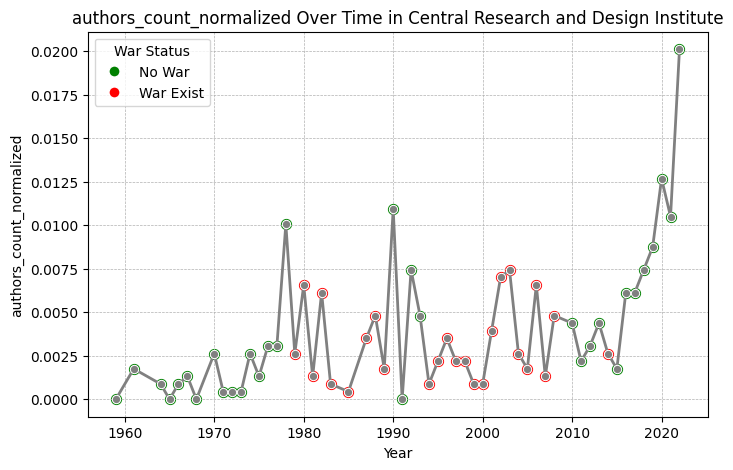

In [103]:
plot_country_yearly_data(ru_author_data_norm, 'Central Research and Design Institute', 'authors_count_normalized')

(67, 8)


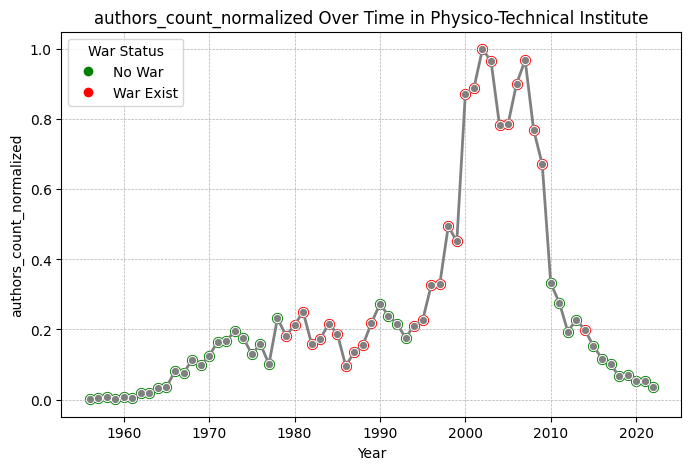

In [137]:
plot_country_yearly_data(ru_author_data_norm, 'Physico-Technical Institute', 'authors_count_normalized')

In [106]:
def categorize_authors_count(df):
    """
    Categorizes institutions based on their max authors_count into four groups:
    Small, Medium-Small, Medium, and Large.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing 'institution_name' and 'authors_count'.

    Returns:
    pd.DataFrame: Updated DataFrame with a new column 'scale_category' based on max authors count.
    """

    # Step 1: Compute the max authors_count per institution
    max_authors_per_inst = df.groupby("institution_name")["authors_count"].max().reset_index()
    max_authors_per_inst.rename(columns={"authors_count": "max_authors"}, inplace=True)

    # Step 2: Compute quartiles based on max authors count
    q1, q2, q3 = max_authors_per_inst["max_authors"].quantile([0.25, 0.5, 0.75]).values

    # Step 3: Categorization function
    def categorize(value):
        if value < q1:
            return "Small"
        elif q1 <= value < q2:
            return "Medium-Small"
        elif q2 <= value < q3:
            return "Medium"
        else:
            return "Large"

    # Step 4: Apply categorization
    max_authors_per_inst["scale_category"] = max_authors_per_inst["max_authors"].apply(categorize)

    # Step 5: Merge back with the original dataframe to include categories
    df = df.merge(max_authors_per_inst, on="institution_name", how="left")

    return df



# plot_yearly_data(ru_author_data, 'authors_count_normalized')

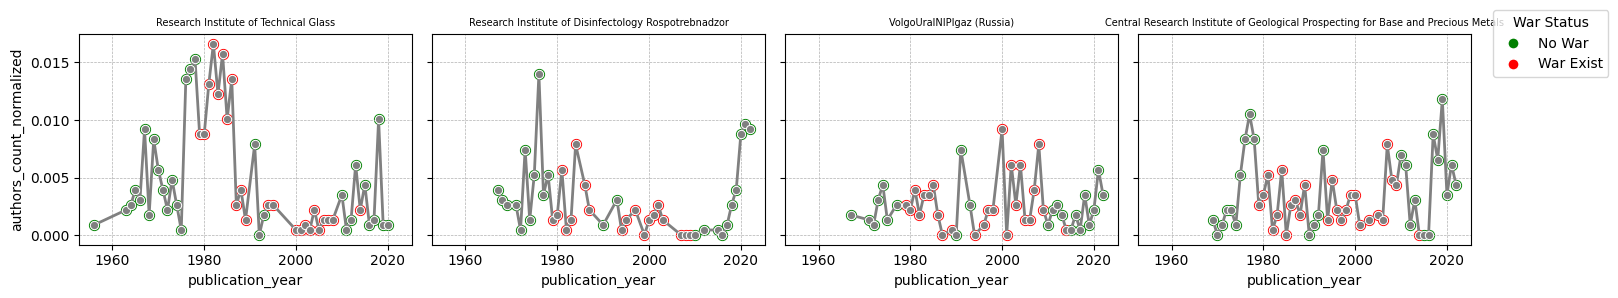

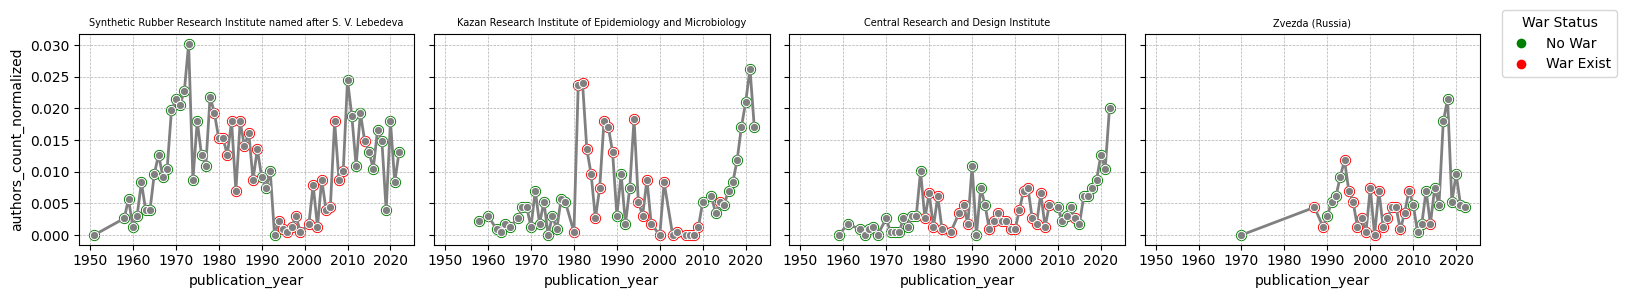

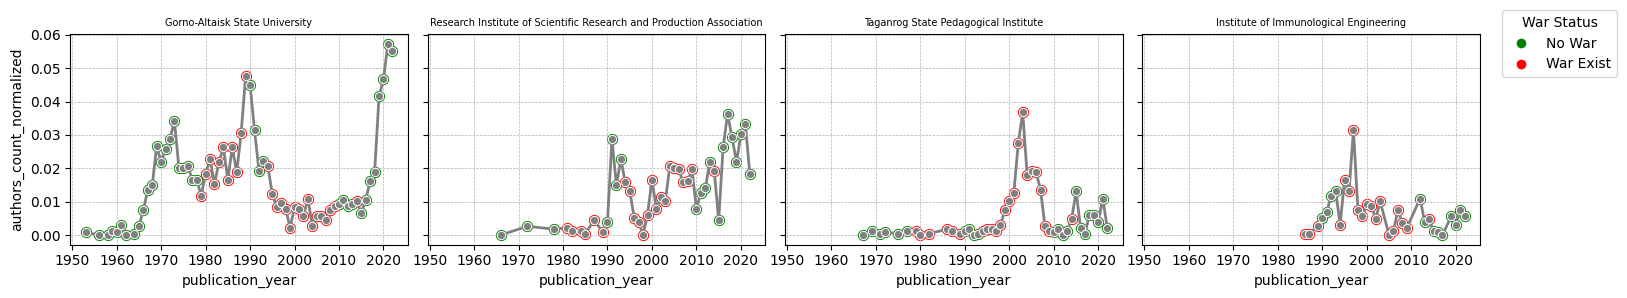

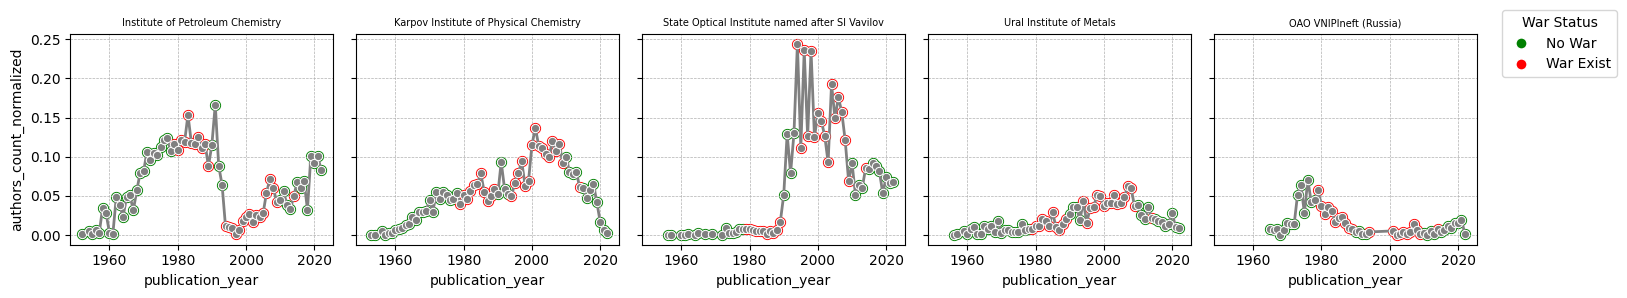

In [121]:
ru_author_data = ru_author_data_norm[ru_author_data_norm["institution_name"] != "Physico-Technical Institute"]
categorized_df = categorize_authors_count(ru_author_data)

for category in ["Small", "Medium-Small", "Medium", "Large"]:
    group_df = categorized_df[categorized_df["scale_category"]==category]
    plot_yearly_data(group_df,'authors_count_normalized')

### Create institutions from-to data frame

In [122]:
def create_consecutive_year_pairs(df1, df2):
    """
    Create pairs of institution names and war statuses for authors between two consecutive years.

    Args:
        df1 (pd.DataFrame): DataFrame for the first year.
        df2 (pd.DataFrame): DataFrame for the second year.

    Returns:
        pd.DataFrame: DataFrame with columns `institution_name_from`, `institution_name_to`, `war_status_from`, `war_status_to`, and `author_name`.
    """
    # Ensure both DataFrames are sorted by `author_name` and `institution_name`
    df1 = df1.sort_values(by=["author_name", "institution_name"]).reset_index(drop=True)
    df2 = df2.sort_values(by=["author_name", "institution_name"]).reset_index(drop=True)

    # Merge the two DataFrames to find consecutive year pairs
    merged_df = pd.merge(
        df1, df2,
        on="author_name",
        suffixes=("_from", "_to")
    )
    # Select and rename relevant columns
    result_df = merged_df[[
        "publication_year_from", "publication_year_to", "institution_name_from", "institution_name_to", "author_name", "war_exist_from", "war_exist_to"
    ]]

    result_df = result_df[result_df["institution_name_from"] != result_df["institution_name_to"]]

    # Rename columns for clarity
    result_df.rename(columns={
        "war_exist_from": "war_status_from",
        "war_exist_to": "war_status_to"
    }, inplace=True)

    return result_df


In [130]:
def process_war_data_institution(input_dir, year_min, year_max, country_code):
    """
    Process war data from pickle files in the given directory.

    Args:
        input_dir (str): Directory where yearly pickle files are stored.
        iso_conversion_func (function): Function to convert 2-letter ISO codes to 3-letter ISO codes.

    Returns:
        pd.DataFrame: Combined DataFrame with war counts by country and year.
    """
    # List all pickle files in the directory
    pickle_files = [f for f in os.listdir(input_dir) if f.endswith(".pkl")]

    # Initialize a list to store results
    all_consecutive_years = []

    pickle_file = f'year_{year_min}.pkl'
    file_path = os.path.join(input_dir, pickle_file)
    df_prev = pd.read_pickle(file_path)
    df_prev = df_prev[df_prev['country_code'] == country_code]
    
    # Loop through each pickle file
    for year in range(year_min+1, year_max+1):
        # Read the pickle file into a DataFrame
        # year = int(pickle_file.split("_")[-1].replace(".pkl", ""))  
        pickle_file = f'year_{year}.pkl'
        file_path = os.path.join(input_dir, pickle_file)
        df_next = pd.read_pickle(file_path)
        df_next = df_next[df_next['country_code'] == country_code]
        consecutive_year = create_consecutive_year_pairs(df_prev, df_next)
        all_consecutive_years.append(consecutive_year)

        df_prev=df_next

    # Concatenate all DataFrames into one
    if all_consecutive_years:
        final_df = pd.concat(all_consecutive_years, ignore_index=True)
    else:
        final_df = pd.DataFrame()  # Return empty DataFrame if no data

    return final_df


In [129]:
# Define a function to create a filtered DataFrame
def filter_by_publication_year(df, year):
    
    df = df[df["publication_year_from"] == year]
    df_group = df.groupby([
        "publication_year_from", 
        "publication_year_to", 
        "institution_name_from", 
        "institution_name_to"
    ], as_index=False).agg({
        'war_status_from': 'first',  # Keep first occurrence
        'war_status_to': 'first',    # Keep first occurrence
        'author_name': 'count'       # Count occurrences
    })

    # Rename the count column appropriately
    df_group.rename(columns={'author_name': 'count'}, inplace=True)
    return df_group

In [125]:
country_code = 'RU'
war_group = process_war_data_institution(input_dir, 1987, 2017, country_code)
war_group = war_group.drop_duplicates(subset=["publication_year_from", "publication_year_to", "institution_name_from", "institution_name_to", "author_name"])
print(war_group.shape)
war_group.head()

(750054, 7)


,publication_year_from,publication_year_to,institution_name_from,institution_name_to,author_name,war_status_from,war_status_to
0,1987,1988,Institute of Bioorganic Chemistry,Russian Academy of Sciences,A Abdukarimov,1,1
2,1987,1988,Russian Academy of Sciences,Institute of Bioorganic Chemistry,A Abdukarimov,1,1
4,1987,1988,Institute of Experimental Cardiology,Boreskov Institute of Catalysis,A. A. Belyaev,1,1
5,1987,1988,Institute of Cytology and Genetics,Lomonosov Moscow State University,A. A. Boldyrev,1,1
8,1987,1988,Moscow Power Engineering Institute,University of Tyumen,A. A. Bolotov,1,1


In [127]:
ru_war_group = war_group[war_group['institution_name_to'].isin(ru_institution_names)]
ru_war_group.shape


(18262, 7)

### Build graph for each year

In [141]:


def create_and_save_top_degree_graphs(df, year, top_num=100, output_dir=os.path.join(const.data_base_dir,"graphs")):
    """
    Creates multiple directed graphs from the given DataFrame:
    1. Top nodes by total degree (in-degree + out-degree).
    2. Top nodes by in-degree.
    3. Top nodes by out-degree.
    4. Top nodes with the highest delta (in-degree - out-degree).
    5. Top nodes with the lowest delta (in-degree - out-degree).
    
    Each graph is assigned node attributes, and edges are labeled by their degree type.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing edges.
    year (int): The year associated with the graph.
    output_dir (str): Directory to save the graph files.

    Returns:
    None
    """
    print(f"Creating edges in the graph for year {year}...")
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges from the dataframe
    for _, row in df.iterrows():
        G.add_edge(row["institution_name_from"], row["institution_name_to"], weight=row["count"])

    print("Computing in-degree, out-degree, total degree, and delta for each node...")
    in_degree_dict = dict(G.in_degree(weight="weight"))
    out_degree_dict = dict(G.out_degree(weight="weight"))
    total_degree_dict = {node: in_degree_dict.get(node, 0) + out_degree_dict.get(node, 0) for node in G.nodes()}
    delta_degree_dict = {node: in_degree_dict.get(node, 0) - out_degree_dict.get(node, 0) for node in G.nodes()}  # Delta = In - Out

    # Compute war_status mapping (1 if any row has war_status 1, else 0)
    war_status_dict = df.groupby("institution_name_from")[["war_status_from", "war_status_to"]].max().max(axis=1).to_dict()
    target_war_status_dict = df.groupby("institution_name_to")[["war_status_from", "war_status_to"]].max().max(axis=1).to_dict()
    war_status_dict.update(target_war_status_dict)  # Merge both sources and targets

    # Define different ranking methods
    ranking_methods = {
        f"top_{top_num}_degree": sorted(total_degree_dict, key=total_degree_dict.get, reverse=True)[:top_num],
        f"top_{top_num}_in_degree": sorted(in_degree_dict, key=in_degree_dict.get, reverse=True)[:top_num],
        f"top_{top_num}_out_degree": sorted(out_degree_dict, key=out_degree_dict.get, reverse=True)[:top_num],
        f"top_{top_num}_lowest_delta": sorted(delta_degree_dict, key=delta_degree_dict.get)[:top_num],  # Lowest delta
        f"top_{top_num}_highest_delta": sorted(delta_degree_dict, key=delta_degree_dict.get, reverse=True)[:top_num],  # Highest delta
    }

    for graph_name, top_nodes in ranking_methods.items():
        print(f"Creating subgraph for {graph_name}...")

        # Extract subgraph
        G_top = G.subgraph(top_nodes).copy()

        # Assign attributes to nodes
        nx.set_node_attributes(G_top, war_status_dict, name="war_status")
        nx.set_node_attributes(G_top, in_degree_dict, name="in_degree")
        nx.set_node_attributes(G_top, out_degree_dict, name="out_degree")
        nx.set_node_attributes(G_top, total_degree_dict, name="total_degree")
        nx.set_node_attributes(G_top, delta_degree_dict, name="delta_degree")  # New attribute
        nx.set_node_attributes(G_top, {node: node for node in G_top.nodes()}, name="label")

        # Assign edge attributes
        edge_attributes = {}
        for u, v, data in G_top.edges(data=True):
            edge_type = "in-degree" if in_degree_dict.get(v, 0) > in_degree_dict.get(u, 0) else "out-degree"
            
            edge_attributes[(u, v)] = {
                "weight": data.get("weight", 1),
                "edge_type": edge_type,  # New attribute for Gephi
            }
        nx.set_edge_attributes(G_top, edge_attributes)

        # Save the graph
        file_path = os.path.join(output_dir, f"{graph_name}_{year}.graphml")
        nx.write_graphml(G_top, file_path)

        print(f"Graph saved successfully as '{file_path}'!")

    return G_top
# Example usage:
# create_and_save_top_degree_graphs(small_df, year=2023)


In [142]:
top_num=100
base_graph_path = os.path.join(const.data_base_dir, "graphs")


In [147]:
country_path = os.path.join(base_graph_path, country_code, str(top_num))  # Path for country

file_paths = {}
# year_list = [1987, 1993, 2003, 2012, 2015, 2019]

year_list = [1993, 2003]

for year in year_list:
    year_path = os.path.join(country_path, str(year))  # Path for year inside country
    os.makedirs(year_path, exist_ok=True) 
    df_group_by_year = filter_by_publication_year(ru_war_group, year)
    print(df_group_by_year.shape)
    higest_delta_graph = create_and_save_top_degree_graphs(df_group_by_year, year=year, top_num=top_num, output_dir=year_path)

    file_paths[year] =os.path.join(year_path, f"top_{top_num}_highest_delta_{str(year)}.graphml")  # Path for country




(68, 7)
Creating edges in the graph for year 1993...
Computing in-degree, out-degree, total degree, and delta for each node...
Creating subgraph for top_100_degree...
Graph saved successfully as '/home/reutme/Big_data/final_project/data/graphs/RU/100/1993/top_100_degree_1993.graphml'!
Creating subgraph for top_100_in_degree...
Graph saved successfully as '/home/reutme/Big_data/final_project/data/graphs/RU/100/1993/top_100_in_degree_1993.graphml'!
Creating subgraph for top_100_out_degree...
Graph saved successfully as '/home/reutme/Big_data/final_project/data/graphs/RU/100/1993/top_100_out_degree_1993.graphml'!
Creating subgraph for top_100_lowest_delta...
Graph saved successfully as '/home/reutme/Big_data/final_project/data/graphs/RU/100/1993/top_100_lowest_delta_1993.graphml'!
Creating subgraph for top_100_highest_delta...
Graph saved successfully as '/home/reutme/Big_data/final_project/data/graphs/RU/100/1993/top_100_highest_delta_1993.graphml'!
(209, 7)
Creating edges in the graph f

### Analyze graphs data

In [216]:
def load_graphs(file_paths):
    """
    Load multiple GraphML files into a dictionary of graphs.

    Parameters:
    file_paths (dict): A dictionary mapping years to file paths.

    Returns:
    dict: A dictionary mapping years to NetworkX graphs.
    """
    graphs = {}
    for year, path in file_paths.items():
        graphs[year] = nx.read_graphml(path)
    return graphs

def extract_delta_values(graphs):
    """
    Extract delta degree values for each node across different years.

    Parameters:
    graphs (dict): A dictionary mapping years to NetworkX graphs.

    Returns:
    dict: A dictionary mapping node labels to their delta values across years.
    """
    delta_values = {}
    
    for year, G in graphs.items():
        for node, data in G.nodes(data=True):
            label = data.get("label", node)  # Default to node ID if label not found
            delta_degree = float(data.get("delta_degree", 0))  # Ensure it's a float
            
            if label not in delta_values:
                delta_values[label] = {}
            delta_values[label][year] = delta_degree
    
    return delta_values

def plot_delta_values(delta_values, years):
    """
    Plot a bar chart of delta values for each node across years with customized font.

    Parameters:
    delta_values (dict): A dictionary mapping node labels to their delta values across years.
    years (list): List of years to consider.
    """
    labels = list(delta_values.keys())
    x = np.arange(len(labels))
    width = 0.2  # Bar width

    # Set font properties
    font_properties = {
        "fontsize": 12,  # Change this for different font sizes
        "fontweight": "bold",
        "family": "serif",  # You can use 'sans-serif', 'monospace', etc.
    }

    plt.figure(figsize=(60, 30))
    fig, ax = plt.subplots(figsize=(30, 10))
    
    for i, year in enumerate(years):
        values = [delta_values[label].get(year, 0) for label in labels]
        ax.bar(x + i * width, values, width, label=str(year))

    # Apply custom font to labels and title
    ax.set_xlabel("Node Labels", fontdict=font_properties)
    ax.set_ylabel("Delta Degree", fontdict=font_properties)
    ax.set_title("Delta Degree of Nodes Across Years", fontdict=font_properties)
    
    ax.set_xticks(x + width)
    ax.set_xticklabels(labels, rotation=45, ha="right", fontdict={"fontsize": 10, "family": "serif"})  # Smaller font

    ax.legend()
    
    plt.xticks(rotation=45, fontsize=8, family="serif", fontweight="bold")  # Bold x-ticks
    plt.yticks(fontsize=12, family="serif")
    
    plt.tight_layout()
    plt.show()


def plot_delta_values_interactive(delta_values, years):
    """
    Create an interactive bar chart of delta values for each university across years using Plotly.
    
    Enhancements:
    - Larger figure size
    - Bold university labels
    - Better spacing between universities
    
    Parameters:
    delta_values (dict): A dictionary mapping university names to their delta values across years.
    years (list): List of years to consider.
    """
    labels = list(delta_values.keys())
    
    fig = go.Figure()

    # Add bars for each year, ensuring that universities are grouped
    for year in years:
        values = [delta_values[label].get(year, 0) for label in labels]
        fig.add_trace(go.Bar(
            x=labels,
            y=values,
            name=str(year),
            hoverinfo="x+y",
            marker=dict(line=dict(width=0.4, color="black")),  # Slight border for clarity
        ))

    # Update layout for better visualization
    fig.update_layout(
        title="Delta Degree of Universities Across Years",
        xaxis=dict(
            title="University",
            tickangle=-70,  # Tilt for readability
            tickfont=dict(size=14, family="serif", color="black", weight="bold"),  # **Bold University Labels**
            categoryorder="category ascending",  # Ensure consistent order
            tickmode="array",
            tickvals=list(range(len(labels))),
            ticktext=[f"<b>{label}</b>" for label in labels],  # **Bold Text for Universities**
        ),
        yaxis=dict(
            title="Delta Degree",
            tickfont=dict(size=14, family="serif", color="black", weight="bold")  # Bold y-axis labels
        ),
        barmode="group",  # Grouped bars (side by side for same university)
        bargap=0.2,  # Spacing between bars within groups
        bargroupgap=0.3,  # Space between different universities
        legend_title="Year",
        font=dict(family="serif", size=14, color="black"),
        width=1600,  # **Wider figure**
        height=800  # **Taller figure**
    )

    fig.show()


def plot_delta_values_interactive(delta_values, years):
    """
    Create an interactive bar chart of delta values for each university across years using Plotly.
    Removes the maximum delta value per year before plotting.

    Parameters:
    delta_values (dict): A dictionary mapping university names to their delta values across years.
    years (list): List of years to consider.
    """
    labels = list(delta_values.keys())

    # Find the max delta per year and exclude it
    max_values = {year: max([delta_values[label].get(year, float('-inf')) for label in labels]) for year in years}

    fig = go.Figure()

    # Add bars for each year, filtering out the max delta value
    for year in years:
        values = [delta_values[label].get(year, 0) if delta_values[label].get(year, 0) < max_values[year] else 0 for label in labels]
        
        fig.add_trace(go.Bar(
            x=labels,
            y=values,
            name=str(year),
            hoverinfo="x+y",
            marker=dict(line=dict(width=0.4, color="black")),  # Slight border for clarity
        ))

    # Update layout for better visualization
    fig.update_layout(
        title="Delta Degree of Universities Across Years (Max Value Removed)",
        xaxis=dict(
            title="University",
            tickangle=-90,  # Tilt for readability
            tickfont=dict(size=16, family="serif", color="black", weight="bold"),  # **Bold University Labels**
            categoryorder="category ascending",  # Ensure consistent order
            tickmode="array",
            tickvals=list(range(len(labels))),
            ticktext=[f"<b>{label}</b>" for label in labels],  # **Bold Text for Universities**
        ),
        yaxis=dict(
            title="Delta Degree",
            tickfont=dict(size=14, family="serif", color="black", weight="bold")  # Bold y-axis labels
        ),
        barmode="group",  # Grouped bars (side by side for same university)
        bargap=0.2,  # Spacing between bars within groups
        bargroupgap=0.3,  # Space between different universities
        legend_title="Year",
        font=dict(family="serif", size=14, color="black"),
        width=1600,  # **Wider figure**
        height=1000  # **Taller figure**
    )

    fig.show()



In [217]:

# Load graphs
graphs = load_graphs(file_paths)

# Extract delta degree values
delta_values = extract_delta_values(graphs)

In [218]:
plot_delta_values_interactive(delta_values, years=list(file_paths.keys()))